In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import vrpSolver

## Solving TSP with different IP formulations

In this notebook, we are going to demostrate the efficiency of different IP formulations for solving the TSP. Including
- DFJ formulation
    - Lazy cut (when we find a violation of subtour constraint, add the lazy cut and go on)
    - Plain loop (when we find a violation of subtour constraint, restart the IP)
- MTZ formulation
- Multi-commodity formulation
- Shortest path formulation (or time-staged formulation)
- Quadratic formulation

### 0. Preparation
In this section, we will randomly generate TSP instances

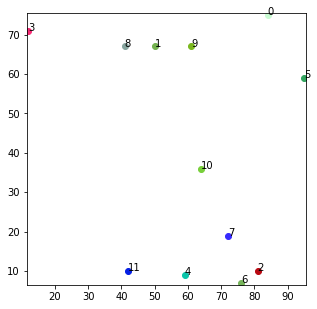

In [2]:
# Generate and plot instance
nodes = vrpSolver.rndPlainNodes(N = 12)
fig, ax = vrpSolver.plotNodes(
    nodes = nodes)
fig

### 1. DFJ formulation

Define the decision variable $x_{ij}$ as the following

\begin{equation}
    x_{ij} = \begin{cases}
        1, &\text{if goes from } i \text{ to } j\\ 
        0, & \text{otherwise}
    \end{cases}, \quad (i, j) \in A
\end{equation}

IP formulation:


\begin{align}
    \min \quad &\sum_{(i, j)\in A} c_{ij}x_{ij}\\
    \text{s.t.} \quad & \sum_{j \in V, (i,j)\in A} x_{ij} = 1, \quad \forall i \in V \label{TSP:con:degree1}\\
                      & \sum_{i \in V, (i,j)\in A} x_{ij} = 1, \quad \forall j \in V \label{TSP:con:degree2}\\
				      & \sum_{j\notin S, i\in S, (i,j)\in A} x_{ij} \ge 1, \quad \forall S \subset V, 2\le |S| \le n-1 \label{TSP:con:DFJSubtour1}\\
                      & x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A   
\end{align}




In [3]:
# DFJ with lazy cut
DFJ_Lazy = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "DFJ_Lazy",
    timeLimit = 300)
print(DFJ_Lazy)

Academic license - for non-commercial use only
{'ofv': 271.11489454680446, 'seq': [0, 5, 10, 7, 2, 6, 4, 11, 3, 8, 1, 9, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 271.11489454680446, 'upperBound': 271.11489454680446, 'runtime': 0.10688972473144531, 'fml': 'DFJ_Lazy', 'serviceTime': 0}


The following figure shows the result for TSP, since every formulation will yield to the same result, we are not going to repeat this part

In [4]:
# Plot the result of TSP
fig, ax = vrpSolver.plotSeq(
    fig = fig,
    ax = ax,
    nodes=nodes, 
    seq=DFJ_Lazy['seq'])

In [5]:
# DFJ with plain loop
DFJ_PlainLoop = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "DFJ_PlainLoop",
    timeLimit = 300)
print(DFJ_PlainLoop)

{'ofv': 271.11489454680446, 'seq': [0, 9, 1, 8, 3, 11, 4, 6, 2, 7, 10, 5, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 271.11489454680446, 'upperBound': 271.11489454680446, 'runtime': 0.00299835205078125, 'fml': 'DFJ_PlainLoop', 'serviceTime': 0}


### 2. MTZ formulation

Define the decision variable $x_{ij}$ as the following

\begin{equation}
    x_{ij} = \begin{cases}
        1, &\text{if goes from } i \text{ to } j\\ 
        0, & \text{otherwise}
    \end{cases}, \quad (i, j) \in A
\end{equation}

Define $t_i$ as the time of visisting vertex $i$

IP formulation:


\begin{align}
    \min \quad &\sum_{(i, j)\in A} c_{ij}x_{ij}\\
    \text{s.t.} \quad & \sum_{j \in V, (i,j)\in A} x_{ij} = 1, \quad \forall i \in V\\
                      & \sum_{i \in V, (i,j)\in A} x_{ij} = 1, \quad \forall j \in V\\
					  & t_i + \tau_{ij} \le t_j  + M(1 - x_{ij}), \quad i, j = 2, \cdots, n \in V, (i, j) \in A\\
                      & x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A\\
					  & t_i \ge 0, \quad i \in 1, \cdots, n \in V
\end{align}


In [6]:
# MTZ
MTZ = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "MTZ",
    timeLimit = 300)
print(MTZ)

{'ofv': 271.11489454680446, 'seq': [0, 9, 1, 8, 3, 11, 4, 6, 2, 7, 10, 5, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 271.11489454680446, 'upperBound': 271.11489454680446, 'runtime': 0.13967514038085938, 'fml': 'MTZ', 'serviceTime': 0}


### 3. Multi-Commodity flow formulation

Define the decision variable $x_{ij}$ as the following

\begin{equation}
    x_{ij} = \begin{cases}
        1, &\text{if goes from } i \text{ to } j\\ 
        0, & \text{otherwise}
    \end{cases}, \quad (i, j) \in A
\end{equation}

Define $y_{ij}^k$ as commodity flow for the $k$th commodity when traveling through edge $(i, j)$

IP formulation:


\begin{align}
    \min \quad &\sum_{(i, j)\in A} c_{ij}x_{ij}\\
    \text{s.t.} \quad & \sum_{j \in V, (i,j)\in A} x_{ij} = 1, \quad \forall i \in V\\
                      & \sum_{i \in V, (i,j)\in A} x_{ij} = 1, \quad \forall j \in V\\
					  & y_{ij}^k \le x_{ij}, \quad \forall i, j, k \in N, k \neq 1\\
					  & \sum_{i \in V} y_{1i}^k = 1, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{i \in V} y_{i1}^k = 0, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{i \in V} y_{ik}^k = 1, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{j \in V} y_{kj}^k = 0, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{i \in V} y_{ij}^k - \sum_{i \in V} y_{ji}^k = 0, \quad \forall j, k \in V \setminus \{1\}, j \neq k\\
                      & x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A\\
                      & y_{ij}^k \in \mathbb{Z}, \quad \forall i, j, k \in N, k \neq 1\\
\end{align}


In [7]:
# MultiCommodityFlow
MultiCommodityFlow = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "MultiCommodityFlow",
    timeLimit = 300)
print(MultiCommodityFlow)

{'ofv': 271.11489454680446, 'seq': [0, 5, 10, 7, 2, 6, 4, 11, 3, 8, 1, 9, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 271.11489454680446, 'upperBound': 271.11489454680446, 'runtime': 0.026966094970703125, 'fml': 'MultiCommodityFlow', 'serviceTime': 0}


### 4. Shortest path formulation (time-staged formulation)

Define $x_{ij}^t$ as the following

\begin{equation}
    x_{ij}^t = \begin{cases}
                    1, \quad \text{If path crosses arc } (i, t) \text{ and } (j, t + 1) \\
                    0, \quad \text{Otherwise}
                \end{cases}, \quad i \in V, j \in V \setminus \{i\}, t = 1, \cdots, n
\end{equation}

IP formulation:

\begin{align}
    \min \quad &\sum_{i \in V}\sum_{j \in V\setminus \{i\}} c_{ij} \sum_{t = 1}^n x_{ij}^t\\
    \text{s.t.} \quad &\sum_{j \in V \setminus \{1\}} x_{1j}^1 = 1\\
    &\sum_{j \in V \setminus \{1, i\}} x_{ij}^2 - x_{1i}^1 = 0, \quad \forall i \in V \setminus \{1\} \\
    &\sum_{j \in V \setminus \{1, i\}} x_{ij}^t - \sum_{j \in V \setminus \{1, i\}} x_{ji}^{t - 1} = 0, \quad \forall i \in V \setminus \{1\}, t \in \{2, \dots, n - 1\}\\
    &x_{i1}^n - \sum_{j \in V \setminus \{1, i\}} x_{ji}^{n - 1} = 0, \quad \forall i \in V \setminus \{1\} \\
    &\sum_{i \in V \setminus \{1\}} x_{i1}^n = 1\\
    &\sum_{t = 2}^{n - 1}\sum_{j \in V \setminus \{1, i\}} x_{ij}^t + x_{i1}^n \le 1, \quad \forall i \in V \setminus \{1\}\\ 
    &x_{1i}^1 + \sum_{t = 2}^{n - 1}\sum_{j \in V \setminus \{1, i\}} x_{ji}^t \le 1, \quad \forall i \in V \setminus \{1\}\\
\end{align}

In [8]:
# ShortestPath
ShortestPath = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "ShortestPath",
    timeLimit = 300)
print(ShortestPath)

{'ofv': 271.11489454680446, 'seq': [0, 9, 1, 8, 3, 11, 4, 6, 2, 7, 10, 5, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 271.11489454680446, 'upperBound': 271.11489454680446, 'runtime': 0.06500244140625, 'fml': 'ShortestPath', 'serviceTime': 0}


### 5. Quadratic formulation

Assuming we have $n$ boxes, which represents $n$ steps in the path. Define $x_{ij}$ as 

\begin{equation}
    x_{ij} = \begin{cases}
                1, \quad \text{Vertex $i$ is assigned to box $j$}\\
                0, \quad \text{Otherwise}
            \end{cases}
\end{equation}

IP formulation:

\begin{align}
    \min \quad & \sum_{i \in V} \sum_{j \in V \setminus \{i\}} \sum_{k = 1}^{n - 1} c_{ij} w_{ij}^k + \sum_{i \in V} \sum_{j \in V \setminus \{i\}} c_{ij}w_{ij}^n\\
    \text{s.t.} \quad & \sum_{j = 1}^n x_{ij} = 1, \quad \forall i \in V\\
                      & \sum_{i \in V}^n x_{ij} = 1, \quad j = 1, \dots, n\\
                      & w_{ij}^k \ge x_{ik} + x_{j, k + 1} - 1, \quad i \in V,  j \in V \setminus \{i\}, k = 1, \cdots, n - 1\\
                      & w_{ij}^k \ge x_{ik} + x_{j1} - 1, \quad i \in V, j \in V \setminus \{i\}, k = n \\
                      & w_{ij}^k \in \{0, 1\}, \quad i \in V, j \in V \setminus \{i\}, k = 1, \dots, n\\
                      & x_{ij} \in \{0, 1\}, \quad i \in V, j \in V \setminus \{i\}
\end{align}

In [9]:
# QAP
QAP = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "QAP",
    timeLimit = 300)
print(QAP)

{'ofv': 271.11489454680446, 'seq': [0, 9, 1, 8, 3, 11, 4, 6, 2, 7, 10, 5, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 271.11489454680446, 'upperBound': 271.11489454680446, 'runtime': 27.258962631225586, 'fml': 'QAP', 'serviceTime': 0}
